ФИО: Гарипов Тимур Исмагилевич

Группа: 317

In [91]:
import numpy as np
import pandas as pd
from collections import defaultdict
import math
import time
import sys
import sklearn
import sklearn.neighbors
import sklearn.tree
import sklearn.ensemble
import matplotlib.pyplot as plt
%matplotlib inline

Все эксперименты в этой лабораторной работе предлагается проводить на данных соревнования Amazon Employee Access Challenge: https://www.kaggle.com/c/amazon-employee-access-challenge

В данной задаче предлагается предсказать, будет ли одобрен запрос сотрудника на получение доступа к тому или иному ресурсу. Все признаки являются категориальными.

Для удобства данные можно загрузить по ссылке: https://www.dropbox.com/s/q6fbs1vvhd5kvek/amazon.csv

Сразу прочитаем данные и создадим разбиение на обучение и контроль:

In [2]:
data = pd.read_csv('amazon.csv')
data.head()

,ACTION,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE
0,1,39353,85475,117961,118300,123472,117905,117906,290919,117908
1,1,17183,1540,117961,118343,123125,118536,118536,308574,118539
2,1,36724,14457,118219,118220,117884,117879,267952,19721,117880
3,1,36135,5396,117961,118343,119993,118321,240983,290919,118322
4,1,42680,5905,117929,117930,119569,119323,123932,19793,119325


In [3]:
data.shape

(32769, 10)

In [4]:
# доля положительных примеров
data.ACTION.mean()

0.94210992096188473

In [5]:
# число значений у признаков
for col_name in data.columns:
    print col_name, len(data[col_name].unique())

ACTION 2
RESOURCE 7518
MGR_ID 4243
ROLE_ROLLUP_1 128
ROLE_ROLLUP_2 177
ROLE_DEPTNAME 449
ROLE_TITLE 343
ROLE_FAMILY_DESC 2358
ROLE_FAMILY 67
ROLE_CODE 343


In [6]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data.iloc[:, 1:], data.iloc[:, 0],
                                                    test_size=0.3, random_state=241)
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

## Часть 1: kNN и категориальные признаки

#### 1. Реализуйте три функции расстояния на категориальных признаках, которые обсуждались на втором семинаре. Реализуйте самостоятельно метод k ближайших соседей, который будет уметь работать с этими функциями расстояния (учитите, что он должен возвращать вероятность — отношение объектов первого класса среди соседей к числу соседей). Как вариант, можно реализовать метрики как [user-defined distance](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.DistanceMetric.html), после чего воспользоваться реализацией kNN из sklearn (в этом случае используйте функцию predict_proba).

#### Подсчитайте для каждой из метрик качество на тестовой выборке `X_test` при числе соседей $k = 10$. Мера качества — AUC-ROC.

Какая функция расстояния оказалась лучшей?

In [20]:
counts = []
p2_sum = []
def precalc(X_train):
    global counts, p2_sum
    L = X_train.shape[0]
    d = X_train.shape[1]    
    counts = []
    p2_sum = []
    for feat_num in range(d):            
        counts.append(defaultdict(int))
        for i in range(L):
            counts[-1][X_train[i, feat_num]] += 1    
    
    for feat_num in range(d):            
        p2_sum.append(defaultdict(float))
        for key, cnt in counts[feat_num].items():
            for other_key, other_cnt in counts[feat_num].items():
                if other_cnt <= cnt:
                    p2_sum[-1][key] += other_cnt * 1.0 * (other_cnt - 1) / L / (L - 1)

In [21]:
%time precalc(X_train)

CPU times: user 59.2 s, sys: 536 ms, total: 59.7 s
Wall time: 59.5 s


In [47]:
def my_knn(X_train, y_train, X_test, metric, n_neighbors=10, B=100):
    L, d = X_train.shape
    N = X_test.shape[0]
    prob = np.array([])
        
    #trainset precalc
    V = np.array(X_train)        
    if metric == 1:
        V_p2_sum = np.zeros(V.shape)
        for j in range(L):
            for k in range(d):
                V_p2_sum[j, k] = p2_sum[k][V[j, k]]

    if metric == 2:
        V_f_log = np.zeros(V.shape)
        for j in range(L):
            for k in range(d):
                V_f_log[j, k] = math.log(1.0 + counts[k][V[j, k]])
                
        U_f_log = np.zeros(X_test.shape)
        for i in range(N):
            for k in range(d):
                U_f_log[i, k] = math.log(1.0 + counts[k][X_test[i, k]])
    
    
    #split trainset on batches
    for i in range(0, N, B):                
        r = min(N, i + B)
        U = np.array(X_test)[i:r, :];
        
        #calculate dist  between U and V objects
        NE = (U[:, np.newaxis, :] != V[np.newaxis, :, :]).astype('float64')
        E = 1.0 - NE
        if metric == 0:
            dist = np.sum(NE, axis=2)
        elif metric == 1:            
            dist = np.sum(NE + E * V_p2_sum[np.newaxis, :, :], axis=2)
        elif metric == 2:           
            dist = np.sum(NE * V_f_log[np.newaxis, :, :] * U_f_log[i:r, np.newaxis, :], axis=2)
                    
        #process neighbors                  
        ind = np.argpartition(dist, n_neighbors, axis=1)[:, :n_neighbors]                
        cur = np.mean(np.array(y_train)[ind], axis=1)        
        prob = np.concatenate((prob, cur))
        
        sys.stdout.write('.')        
        sys.stdout.flush()
    print ''
    return prob

Метрика 0: $\rho(x_j, z_j) = [x_j \neq z_j]$

Метрика 1: $\rho(x_j, z_j) = [x_j \neq z_j] + [x_j = z_j] \sum\limits_{q:p_j(q) \leqslant p_j(x_j)} p^2_j(q)$

Метрика 2: $\rho(x_j, z_j) = [x_j \neq z_j] \log{(1 + f_j(x_j))} \log{(1 + f_j(z_j))}$ 

(к аргументам логарифма, добавлены единицы, чтобы метрка была определена для значений, не встречавшихся в обучающей выборке)

In [48]:
for metr in range(3):
    print metr
    prob = my_knn(X_train, y_train, X_test, metr)
    print(prob)    
    print 'AUC-ROC:', sklearn.metrics.roc_auc_score(y_test, prob)
    print ''

0
...................................................................................................
[ 1.   1.   1.  ...,  0.6  1.   0.7]
AUC-ROC: 0.829499015542

1
...................................................................................................
[ 1.   1.   1.  ...,  0.8  1.   0.8]
AUC-ROC: 0.833094317461

2
...................................................................................................
[ 1.   1.   1.  ...,  0.6  1.   0.7]
AUC-ROC: 0.821046030503



## Результаты

Метрика 0: 0.829

Метрика 1: 0.833

Метрика 2: 0.821

Метрика 1 оказалась лучшей.

#### 2 (бонус). Подберите лучшее (на тестовой выборке) число соседей $k$ для каждой из функций расстояния. Какое наилучшее качество удалось достичь?

In [100]:
K = np.arange(2, 21)
res = np.zeros((3, K.size))
for metr in range(3):
    for i in range(K.size):
        print 'mertic:', metr, 'K:', K[i]
        prob = my_knn(X_train, y_train, X_test, metr, n_neighbors=K[i])
        res[metr, i] = sklearn.metrics.roc_auc_score(y_test, prob)
        print 'res: ', res[metr, i]

mertic: 0 K: 2
...................................................................................................
res:  0.754762436194
mertic: 0 K: 3
...................................................................................................
res:  0.807175921433
mertic: 0 K: 4
...................................................................................................
res:  0.821479763443
mertic: 0 K: 5
...................................................................................................
res:  0.825476540143
mertic: 0 K: 6
...................................................................................................
res:  0.830887284427
mertic: 0 K: 7
...................................................................................................
res:  0.836308721527
mertic: 0 K: 8
...................................................................................................
res:  0.835008690833
mertic: 0 K: 9
.................................

metric 0 max:  0.836308721527 K: 7
metric 1 max:  0.834311770867 K: 7
metric 2 max:  0.821608885927 K: 9


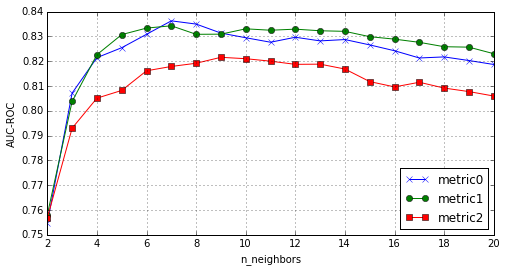

In [102]:
for i in range(3):
    print 'metric', i,  'max: ', np.max(res[i, :]), 'K:', K[np.argmax(res[i, :])]

plt.figure(figsize=(8, 4))
plt.grid()
plt.plot(K, res[0, :], 'x-', label='metric0')
plt.plot(K, res[1, :], 'o-', label='metric1')
plt.plot(K, res[2, :], 's-', label='metric2')
plt.xlabel('n_neighbors')
plt.ylabel('AUC-ROC')
plt.legend(loc=4)
plt.show()

## Результаты 

Метрика 0. Максимальное качество  0.836  при k = 7.

Метрика 1. Максимальное качество  0.834  при k = 7.

Метрика 2. Максимальное качество  0.821  при k = 9.

Наилучшее качество  0.836

#### 3. Реализуйте счетчики (http://blogs.technet.com/b/machinelearning/archive/2015/02/17/big-learning-made-easy-with-counts.aspx), которые заменят категориальные признаки на вещественные.

А именно, каждый категориальный признак нужно заменить на три: 
1. Число `counts` объектов в обучающей выборке с таким же значением признака.
2. Число `clicks` объектов первого класса ($y = 1$) в обучающей выборке с таким же значением признака.
3. Сглаженное отношение двух предыдущих величин: (`clicks` + 1) / (`counts` + 2).

Поскольку признаки, содержащие информацию о целевой переменной, могут привести к переобучению, может оказаться полезным сделать *фолдинг*: разбить обучающую выборку на $n$ частей, и для $i$-й части считать `counts` и `clicks` по всем остальным частям. Для тестовой выборки используются счетчики, посчитанный по всей обучающей выборке. Реализуйте и такой вариант. Можно использовать $n = 3$.

#### Посчитайте на тесте AUC-ROC метода $k$ ближайших соседей с евклидовой метрикой для выборки, где категориальные признаки заменены на счетчики. Сравните по AUC-ROC два варианта формирования выборки — с фолдингом и без. Не забудьте подобрать наилучшее число соседей $k$.

In [7]:
def categorial_to_real(X_train, y_train, X, B=8000):
    d = X_train.shape[1]
    features = np.zeros((X.shape[0], 3 * d))
    N = X.shape[0]
    for k in range(d):
        for i in range(0, N, B):
            r = min(N, i + B)
            E = X[i:r, np.newaxis, k] == X_train[np.newaxis, :, k] # E[i, j] = X[i, k] == X_train[j, k]
            features[i:r, 3 * k] = np.sum(E, axis=1) #counts
            features[i:r, 3 * k + 1] = np.sum(E * y_train[np.newaxis, :], axis = 1) #clicks
            features[i:r, 3 * k + 2] = (features[i:r, 3 * k + 1] + 1.0) / (features[i:r, 3 * k] + 2)
        sys.stdout.write('#')
        sys.stdout.flush()
    sys.stdout.write('\n')
    return features

# фолдинг
def train_folds(X_train, y_train, N = 3):
    L = X_train.shape[0]
    d = X_train.shape[1]
    s = (L + N - 1) / N
    ind = np.arange(L)
    F = np.zeros((L, 3 * d))
    for i in range(0, L, s):
        r = min(L, i + s)
        in_fold = np.arange(i, r)        
        out_of_fold = np.delete(ind, in_fold)        
        f = categorial_to_real(X_train[out_of_fold, :], y_train[out_of_fold], X_train[in_fold, :])
        F[in_fold, :] = f
    
    # counts и clicks умножаются на N / (N - 1) 
    # для того, чтобы признаки на обучающей и тестовой выборке
    # находились в одних и тех же диапазонах
    
    p = N  * 1.0 / (N - 1)
    for k in range(d):
        F[:, 3 * k] *= p
        F[:, 3 * k + 1] *= p
        F[:, 3 * k + 2] = (F[:, 3 * k + 1] + 1.0) / (F[:, 3 * k] + 2)
       
    return F

In [104]:
F_train_folds = train_folds(X_train, y_train)
F_train_nofolds = categorial_to_real(X_train, y_train, X_train)
F_test = categorial_to_real(X_train, y_train, X_test)

In [8]:
def get_score( X_train, y_train, X_test, y_test, n_neighbors):
    classifier = sklearn.neighbors.KNeighborsClassifier(n_neighbors=n_neighbors)
    classifier.fit(X_train, y_train)
    prob = classifier.predict_proba(X_test)[:, 1]
    return sklearn.metrics.roc_auc_score(y_test, prob)

In [106]:
K = np.arange(2, 51)
print 'Folding'
folds_res = np.array([])
for i in range(K.size):    
    folds_res = np.append(folds_res, get_score(F_train_folds, y_train, F_test, y_test, K[i]))
    sys.stdout.write('.')
    sys.stdout.flush()    
print ''

print 'No folding'
nofolds_res = np.array([])
for i in range(K.size):
    nofolds_res = np.append(nofolds_res, get_score(F_train_nofolds, y_train, F_test, y_test, K[i]))
    sys.stdout.write('.')
    sys.stdout.flush()   
print ''

Folding
.................................................
No folding
.................................................


Folding. Max: 0.77653507495 k: 19
No folding. Max: 0.796091066126 k: 14


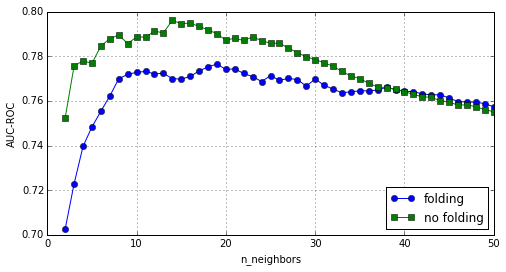

In [107]:
print 'Folding. Max:', np.max(folds_res), 'k:', K[np.argmax(folds_res)]
print 'No folding. Max:', np.max(nofolds_res), 'k:', K[np.argmax(nofolds_res)]

plt.figure(figsize=(8, 4))
plt.grid()
plt.plot(K, folds_res, 'o-', label='folding')
plt.plot(K, nofolds_res, 's-', label='no folding')
plt.xlabel('n_neighbors')
plt.ylabel('AUC-ROC')
plt.legend(loc=4)
plt.show()

## Результаты
С фолдингом.  Максимальное качество 0.776 при k = 19

Без фолдинга. Максимальное качетсво 0.796 при k = 14

#### 4. Добавьте в исходную выборку парные признаки — то есть для каждой пары $f_i$, $f_j$ исходных категориальных признаков добавьте новый категориальный признак $f_{ij}$, значение которого является конкатенацией значений $f_i$ и $f_j$. Посчитайте счетчики для этой выборки, найдите качество метода $k$ ближайших соседей с наилучшим $k$ (с фолдингом и без).

In [9]:
def pair_features(X):
    d = X.shape[1]
    X_pairs = np.recarray(shape=(X.shape[0], d + d * (d - 1) / 2), dtype=[('f1', int), ('f2', int)])
    cnt = 0
    for i in range(X.shape[1]):
        for j in range(i, X.shape[1]):
            X_pairs[:, cnt] = np.core.rec.fromarrays([X[:, i], X[:, j]], dtype=[('f1', int), ('f2', int)])
            cnt = cnt + 1
    return X_pairs

In [10]:
X_train_pairs = pair_features(X_train)
X_test_pairs = pair_features(X_test)

In [11]:
F_train_pairs_nofold = categorial_to_real(X_train_pairs, y_train, X_train_pairs)

#############################################


In [13]:
F_train_pairs_folds = train_folds(X_train_pairs, y_train)

#############################################
#############################################
#############################################


In [14]:
F_test_pairs = categorial_to_real(X_train_pairs, y_train, X_test_pairs)

#############################################


In [89]:
K = np.arange(2, 51)
print 'Folding'
pairs_folds_res = np.array([])
for i in range(K.size):    
    pairs_folds_res = np.append(pairs_folds_res, get_score(F_train_pairs_folds, y_train, F_test_pairs, y_test, K[i]))
    sys.stdout.write('.')
    sys.stdout.flush()    
print ''

print 'No folding'
pairs_nofolds_res = np.array([])
for i in range(K.size):
    pairs_nofolds_res = np.append(pairs_nofolds_res, get_score(F_train_pairs_nofold, y_train, F_test_pairs, y_test, K[i]))
    sys.stdout.write('.')
    sys.stdout.flush()   
print ''

Folding
.................................................
No folding
.................................................


Folding. Max: 0.790223316304 k: 18
No folding. Max: 0.801859076241 k: 8


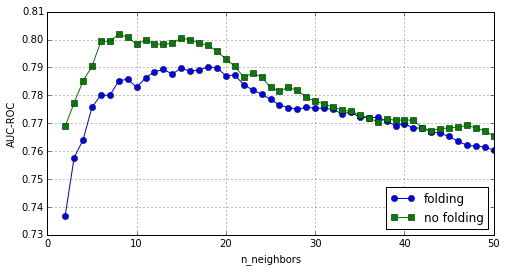

In [90]:
print 'Folding. Max:', np.max(pairs_folds_res), 'k:', K[np.argmax(pairs_folds_res)]
print 'No folding. Max:', np.max(pairs_nofolds_res), 'k:', K[np.argmax(pairs_nofolds_res)]

plt.figure(figsize=(8, 4))
plt.grid()
plt.plot(K, pairs_folds_res, 'o-', label='folding')
plt.plot(K, pairs_nofolds_res, 's-', label='no folding')
plt.xlabel('n_neighbors')
plt.ylabel('AUC-ROC')
plt.legend(loc=4)
plt.show()

## Результаты
С фолдингом.  Максимальное качество 0.790 при k = 18

Без фолдинга. Максимальное качетсво 0.802 при k = 8

## Часть 2: Решающие деревья и леса

#### 1. Возьмите из предыдущей части выборку с парными признаками, преобразованную с помощью счетчиков без фолдинга. Настройте решающее дерево, подобрав оптимальные значения параметров `max_depth` и `min_samples_leaf`. Какой наилучший AUC-ROC на контроле удалось получить?

In [16]:
depth = np.arange(1, 36)
samples = np.arange(1, 11000, 250)
test_score = np.array([])
train_score = np.array([])
for s in samples:
    for d in depth:
        tree_classifier = sklearn.tree.DecisionTreeClassifier(max_depth=d, min_samples_leaf=s)
        tree_classifier.fit(F_train_pairs_nofold, y_train)
        prob = tree_classifier.predict_proba(F_test_pairs)[:, 1]
        test_score = np.append(test_score, sklearn.metrics.roc_auc_score(y_test, prob))
        prob = tree_classifier.predict_proba(F_train_pairs_nofold)[:, 1]
        train_score = np.append(train_score, sklearn.metrics.roc_auc_score(y_train, prob))
    sys.stdout.write('.')
    sys.stdout.flush()

............................................

In [25]:
id = np.argmax(test_score)
print 'Best score:', np.max(test_score), '(train score:', ' ' + str(train_score[id]) + ')'
d_id = id % depth.size
s_id = id / depth.size
print 'max_depth:', depth[d_id]
print 'min_samples_leaf:', samples[s_id]

Best score: 0.802384641595 (train score:  0.922784087712)
max_depth: 2
min_samples_leaf: 1751


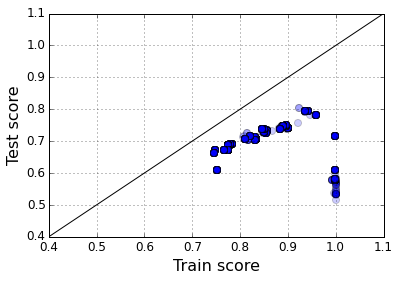

In [64]:
plt.plot([0, 1.1], [0, 1.1], '-', color='black')
plt.scatter(train_score, test_score, s=50, alpha=0.2)
plt.grid()
plt.xlim([0.4, 1.1])
plt.ylim([0.4, 1.1])
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.xlabel('Train score', fontsize=16)
plt.ylabel('Test score', fontsize=16)
plt.show()

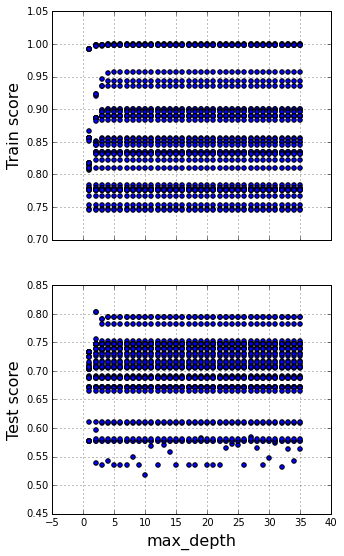

In [84]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(5, 9))
ax1.grid()
ax1.scatter(np.tile(depth, [samples.size]), train_score)
ax1.set_ylabel('Train score', fontsize=16)
ax2.grid()
ax2.scatter(np.tile(depth, [samples.size]), test_score)
ax2.set_ylabel('Test score', fontsize=16)
ax2.set_xlabel('max_depth', fontsize=16)
plt.show()

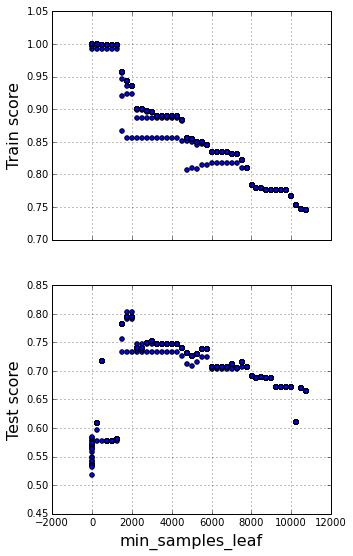

array([    1,     1,   251,   251,   501,   501,   751,   751,  1001,
        1001,  1251,  1251,  1501,  1501,  1751,  1751,  2001,  2001,
        2251,  2251,  2501,  2501,  2751,  2751,  3001,  3001,  3251,
        3251,  3501,  3501,  3751,  3751,  4001,  4001,  4251,  4251,
        4501,  4501,  4751,  4751,  5001,  5001,  5251,  5251,  5501,
        5501,  5751,  5751,  6001,  6001,  6251,  6251,  6501,  6501,
        6751,  6751,  7001,  7001,  7251,  7251,  7501,  7501,  7751,
        7751,  8001,  8001,  8251,  8251,  8501,  8501,  8751,  8751,
        9001,  9001,  9251,  9251,  9501,  9501,  9751,  9751, 10001,
       10001, 10251, 10251, 10501, 10501, 10751, 10751])

In [106]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(5, 9))
ax1.grid()
ax1.scatter(np.repeat(samples, [depth.size]), train_score)
ax1.set_ylabel('Train score', fontsize=16)
ax2.grid()
ax2.scatter(np.repeat(samples, [depth.size]), test_score)
ax2.set_ylabel('Test score', fontsize=16)
ax2.set_xlabel('min_samples_leaf', fontsize=16)
plt.show()

## Результаты
Как видно из графиков, дерево переобучается, однако, изменяя параметр `min_samples_leaf`, можно частично решить эту проблему.

Наилучшее качество на тестовой выборке: 0.802 (при качестве на обучающей выборке:  0.923)

max_depth: 2

min_samples_leaf: 1751


#### 2. Настройте случайный лес, подобрав оптимальное число деревьев `n_estimators`. Какое качество на тестовой выборке он дает?

In [226]:
n_est = np.arange(1, 100, 2)
ens_train_score = np.array([])
ens_test_score = np.array([])
random_forest = sklearn.ensemble.RandomForestClassifier(n_estimators=0, warm_start=True, 
                                                        min_samples_leaf=1011, max_depth=4)
for cnt in n_est:
    random_forest = random_forest.set_params(n_estimators=cnt)
    random_forest.fit(F_train_pairs_nofold, y_train)
    prob = random_forest.predict_proba(F_test_pairs)[:, 1]
    score = sklearn.metrics.roc_auc_score(y_test, prob)
    ens_test_score = np.append(ens_test_score, score)
    prob = random_forest.predict_proba(F_train_pairs_nofold)[:, 1]
    score = sklearn.metrics.roc_auc_score(y_train, prob)
    ens_train_score = np.append(ens_train_score, score)
    sys.stdout.write('.')
    sys.stdout.flush()

..................................................

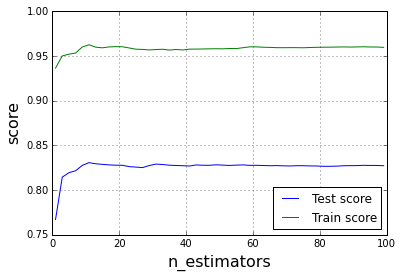

best score: 0.83060127408 (train score: 0.962594514523)
n_estimators: 11


In [227]:
plt.plot(n_est, ens_test_score, label='Test score')
plt.plot(n_est, ens_train_score, label='Train score')
plt.legend(loc=4)
plt.grid()
plt.xlabel('n_estimators', fontsize=16)
plt.ylabel('score', fontsize=16)
plt.show()

print 'best score:', np.max(ens_test_score), '(train score: ' + str(ens_train_score[np.argmax(ens_test_score)])+')'
print 'n_estimators:', n_est[np.argmax(ens_test_score)]

## Результаты

Наилучшее качество на тестовой выборке: 0.831 (при качестве на обучающей выборке:  0.962)

n_estimators: 11


#### 3. Возьмите выборку с парными признаками, для которой счетчики посчитаны с фолдингом. Обучите на ней случайный лес, подобрав число деревьев. Какое качество на тестовой выборке он дает? Чем вы можете объяснить изменение результата по сравнению с предыдущим пунктом?

In [223]:
n_est = np.arange(10, 500, 10)
ens_train_score = np.array([])
ens_test_score = np.array([])
random_forest = sklearn.ensemble.RandomForestClassifier(n_estimators=0, warm_start=True, 
                                                        min_samples_leaf=3)
for cnt in n_est:
    random_forest = random_forest.set_params(n_estimators=cnt)
    random_forest.fit(F_train_pairs_folds, y_train)
    prob = random_forest.predict_proba(F_test_pairs)[:, 1]
    score = sklearn.metrics.roc_auc_score(y_test, prob)
    ens_test_score = np.append(ens_test_score, score)
    prob = random_forest.predict_proba(F_train_pairs_folds)[:, 1]
    score = sklearn.metrics.roc_auc_score(y_train, prob)
    ens_train_score = np.append(ens_train_score, score)
    sys.stdout.write('.')
    sys.stdout.flush()

.................................................

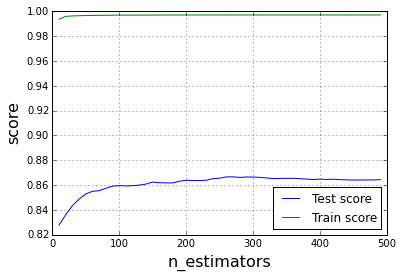

best score: 0.86656354839 (train score: 0.997118308575)
n_estimators: 270


In [225]:
plt.plot(n_est, ens_test_score, label='Test score')
plt.plot(n_est, ens_train_score, label='Train score')
plt.legend(loc=4)
plt.grid()
plt.xlabel('n_estimators', fontsize=16)
plt.ylabel('score', fontsize=16)
plt.show()

print 'best score:', np.max(ens_test_score), '(train score: ' + str(ens_train_score[np.argmax(ens_test_score)])+')'
print 'n_estimators:', n_est[np.argmax(ens_test_score)]

## Результаты

Наилучшее качество на тестовой выборке: 0.867 (при качестве на обучающей выборке:  0.997)

n_estimators: 270

Улучшение качетсва при использовании фолдинга можно объяснить тем, что при подсчете счетчиков без фолдинга в признаки вносится информация о классе объекта, что вызывает проблемы, связанные с переобучением.
    
    